# Creating the Initial Conditions: Monterey Bay

First, import packages to re-create and visualize the model fields here:

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

In [13]:
print(os.getcwd())

/Users/alex/Desktop/MS274/demo/ModelPrep


Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [14]:
# define the input directory
# os.chdir('ModelPrep')
input_dir = ''
input_dir

'/Users/alex/Desktop/MS274/demo/newICs'

## Constructing the Initial Conditions
For my model, I will use a model state from the ECCO LLC4320 state estimate. I will prepare the initial condition fields in 7 steps:
1. download 5 fields generated by the LLC4320 model in 2011
2. read the LLC4320 model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the LLC4320 fields for interpolation
5. interpolate the LLC4320 fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO LLC4320 state estimate. These fields are available [HERE](https://data.nas.nasa.gov/). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (September 2011):

| Variable(s) | File Name |
| -------- | --------- |
|THETA|Theta_960x1754x88.20110913T000000
|SALT|Salt_960x1754x88.20110913T000000
|UVEL and VVEL|[OCEAN_3D_VOLUME_FLUX_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4/OCEAN_3D_VOLUME_FLUX_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc)|
|ETAN|[SEA_SURFACE_HEIGHT_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc)|
|GRID|[GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc)|

I stored these fields in the same directory as this notebook:

In [15]:
data_folder = os.getcwd()

In [16]:
ecco_XC = np.fromfile('XC_960x1754','>f4')
ecco_YC = np.fromfile('YC_960x1754','>f4')
ETA = np.fromfile('Eta_960x1754.20110913T100000','>f4').reshape(1754,960)
THETA = np.fromfile('Theta_960x1754x88.20110913T100000','>f4').reshape(88,1754,960)
SALT = np.fromfile('Salt_960x1754x88.20110913T100000','>f4').reshape(88,1754,960)
U = np.fromfile('U_960x1754x88.20110913T100000','>f4').reshape(88,1754,960)
V = np.fromfile('V_960x1754x88.20110913T100000','>f4').reshape(88,1754,960)

HFACC= np.fromfile('hFacC_960x1754x88','>f4').reshape(88,1754,960)

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [17]:
# define the parameters that will be used in the data file
delX = 1/225
delY = 1/350
xgOrigin = -122.75
ygOrigin = 36.25
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'bathymetry.bin'),'>f4').reshape(np.shape(XC))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alex/Desktop/MS274/demo/newICs/bathymetry.bin'

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [7]:
depth = bathy

delR = np.array([ 1.00,    1.14,    1.30,    1.49,   1.70,
                  1.93,    2.20,    2.50,    2.84,   3.21,
                  3.63,    4.10,    4.61,    5.18,   5.79,
                  6.47,    7.20,    7.98,    8.83,   9.73,
                 10.69,   11.70,   12.76,   13.87,  15.03,
                 16.22,   17.45,   18.70,   19.97,  21.27,
                 22.56,   23.87,   25.17,   26.46,  27.74,
                 29.00,   30.24,   31.45,   32.65,  33.82,
                 34.97,   36.09,   37.20,   38.29,  39.37,
                 40.45,   41.53,   42.62,   43.73,  44.87,
                 46.05,   47.28,   48.56,   49.93,  51.38,
                 52.93,   54.61,   56.42,   58.38,  60.53,
                 62.87,   65.43,   68.24,   71.33,  74.73,
                 78.47,   82.61,   87.17,   92.21,  97.79,
                103.96,  110.79,  118.35,  126.73, 136.01,
                146.30,  157.71,  170.35,  184.37, 199.89,
                217.09,  236.13,  257.21,  280.50, 306.24,
                334.64,  365.93,  400.38,])
hFacC = hFac.create_hFacC_grid(depth, delR,hFacMin=0.3,hFacMinDr=1)
np.shape(hFacC)

(88, 360, 240)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [8]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

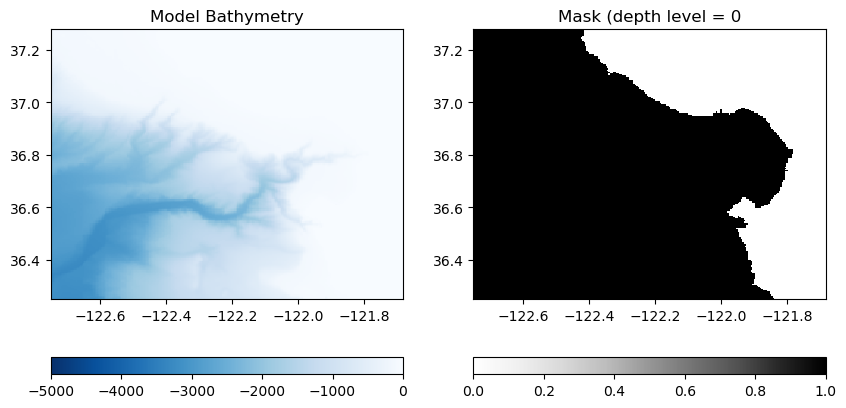

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [24]:
# make a list to hold all of the ECCO grids
init_grids = []

THETA_unraveled = np.zeros((len(delR), np.size(ecco_XC)))
SALT_unraveled = np.zeros((len(delR), np.size(ecco_XC)))
U_unraveled = np.zeros((len(delR), np.size(ecco_XC)))
V_unraveled = np.zeros((len(delR), np.size(ecco_XC)))
mask_unraveled = np.zeros((len(delR), np.size(ecco_XC)))
ETA_unraveled = ETA[:,:].ravel()  # surface variable, 1D only

for k in range(len(delR)):
    THETA_unraveled[k,:] = THETA[k,:,:].ravel()
    SALT_unraveled[k,:] = SALT[k,:,:].ravel()
    U_unraveled[k,:] = U[k,:,:].ravel()
    V_unraveled[k,:] = V[k,:,:].ravel()
    mask_unraveled[k,:] = HFACC[k,:,:].ravel()

mask_unraveled = mask_unraveled > 0

# Append in the same order as variable_names
init_grids = [ETA_unraveled, THETA_unraveled, SALT_unraveled, U_unraveled, V_unraveled]

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [25]:
variable_names=['THETA','SALT','U','V']
# 'ETA',
for variable_name, init_grid in zip(variable_names, init_grids):
    print(variable_name, init_grid.shape)
    print('    - Interpolating the '+variable_name+' grid')

    points = np.column_stack([ecco_XC.ravel(), ecco_YC.ravel()])

    if variable_name == 'ETA':
    # Add a fake vertical level dimension so ETA looks like (1, npoints)
        interpolated_grid = horizontal.downscale_3D_points(
        points,
        init_grid[np.newaxis, :],          # shape (1, npoints)
        mask_unraveled[:1, :],             # shape (1, npoints)
        XC, YC,
        mask[:1, :, :],                    # shape (1, ny, nx)
        )
        #interpolated_grid[interpolated_grid==0]=np.nan
        # 
        #testing=True)
    else:
        interpolated_grid = horizontal.downscale_3D_points(
        points, init_grid, mask_unraveled, XC, YC, mask)
        # interpolated_grid[interpolated_grid==0]=np.nan
        #testing=True)
    output_file = os.path.join(input_dir, variable_name + '_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

THETA (1683840,)
    - Interpolating the THETA grid


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [26]:
meta_dict = {
    #'ETAN':[-0.8, 0, 'viridis', 'm'],
            'THETA':[14, 18, 'turbo', 'm'],
            'SALT':[33, 34, 'viridis', 'm'],
            'UVEL':[-1, 1, 'seismic', 'm'],
            'VVEL':[-1, 1, 'seismic', 'm']}

Then, I'll create all of the subplots:

Central surface THETA is 15.88885
86400
Central surface SALT is 33.653625
86400
Central surface UVEL is -0.20819819
86400
Central surface VVEL is 0.21423294
86400


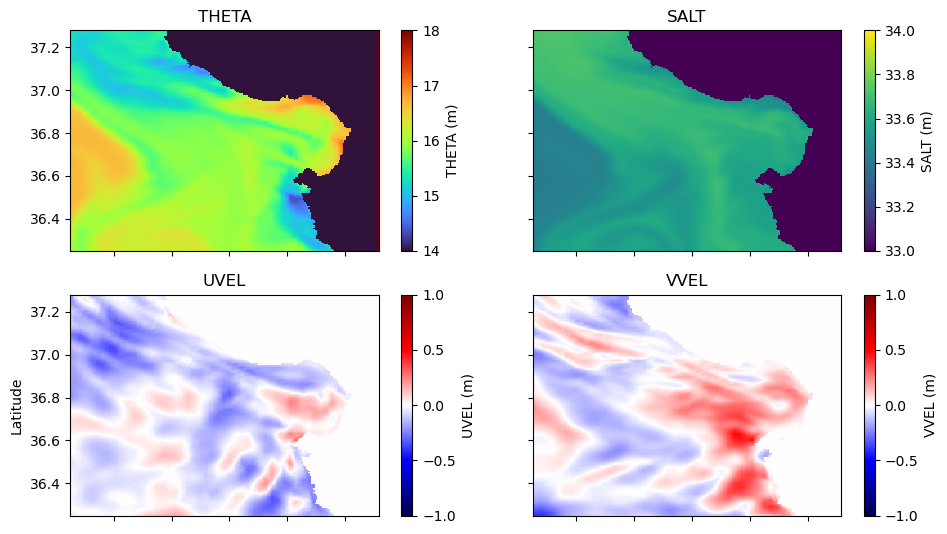

In [29]:
fig = plt.figure(figsize=(10,8))
#'ETAN',
variable_names=['THETA','SALT','UVEL','VVEL']
for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')
    
    # if variable_name == 'ETAN':
    #     CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    #else:
    CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        #CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    CA_init_grid = CA_init_grid[0, :, :] # choose just the surface for plotting
    print('Central surface', variable_names[i],'is',CA_init_grid[180,120])
    plt.subplot(3,2,i+1)
    C = plt.pcolormesh(XC, YC, CA_init_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)
    print(np.size(CA_init_grid))
    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')
    plt.title(variable_name)

plt.tight_layout()
plt.savefig('_LLC4320_ICs.png',dpi=300)
plt.show()

In [25]:
# Define boundaries
boundaries = ['N', 'S', 'W']

for variable_name in variable_names:
    # Load interpolated grid from file
    CA_init_grid = np.fromfile(os.path.join(input_dir, variable_name + '_IC.bin'), '>f4')
    
    if variable_name == 'ETA':
        CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0], np.shape(XC)[0], np.shape(XC)[1]))

    # Loop over each boundary
    for boundary in boundaries:
        if variable_name == 'ETA':
            if boundary == 'N':
                bc_data = CA_init_grid[-1, :]
            elif boundary == 'S':
                bc_data = CA_init_grid[0, :]
            elif boundary == 'W':
                bc_data = CA_init_grid[:, 0]
        else:
            if boundary == 'N':
                bc_data = CA_init_grid[:, -1, :]
            elif boundary == 'S':
                bc_data = CA_init_grid[:, 0, :]
            elif boundary == 'W':
                bc_data = CA_init_grid[:, :, 0]

        # Define output directory and filename
        output_bc_dir = os.path.join(input_dir, 'obcs')
        os.makedirs(output_bc_dir, exist_ok=True)
        output_file = os.path.join(output_bc_dir, f'{variable_name}_{boundary}_2011.bin')

        print(np.min(bc_data),np.max(bc_data))
        # Write file
        bc_data.astype('>f4').tofile(output_file)

        print(f'{variable_name} {boundary} boundary written to {output_file}')

-0.6577842 0.0
ETA N boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/ETA_N_2011.bin
-0.6864664 0.0
ETA S boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/ETA_S_2011.bin
-0.68898964 -0.65418446
ETA W boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/ETA_W_2011.bin
0.0 15.503539
THETA N boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/THETA_N_2011.bin
0.0 16.348148
THETA S boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/THETA_S_2011.bin
0.0 16.708904
THETA W boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/THETA_W_2011.bin
0.0 33.896076
SALT N boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/SALT_N_2011.bin
0.0 34.663227
SALT S boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/SALT_S_2011.bin
0.0 34.66532
SALT W boundary written to /Users/alex/Desktop/MS274/demo/ModelPrep/obcs/SALT_W_2011.bin
-0.19592825 0.13553351
U N boundary written to /Users/alex/Des

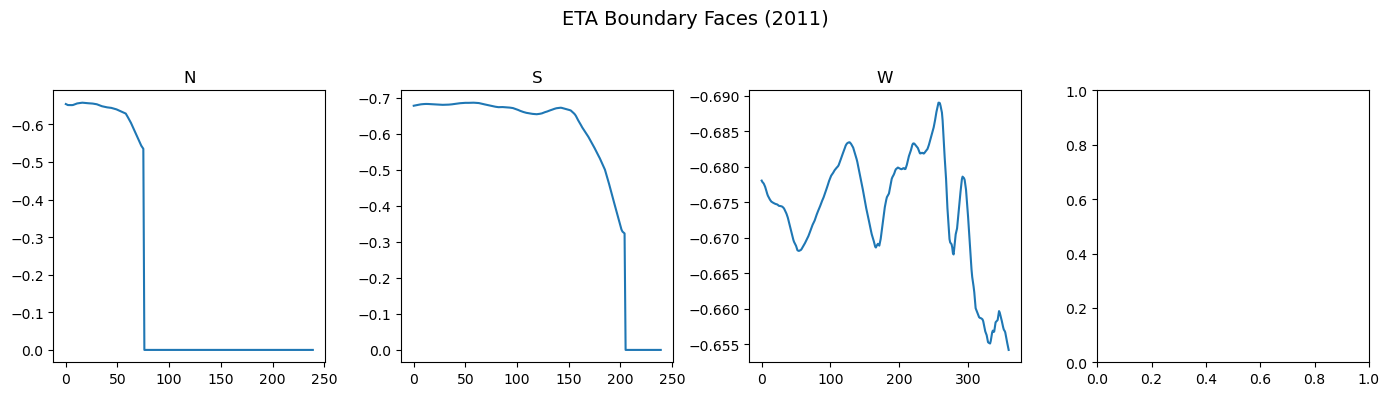

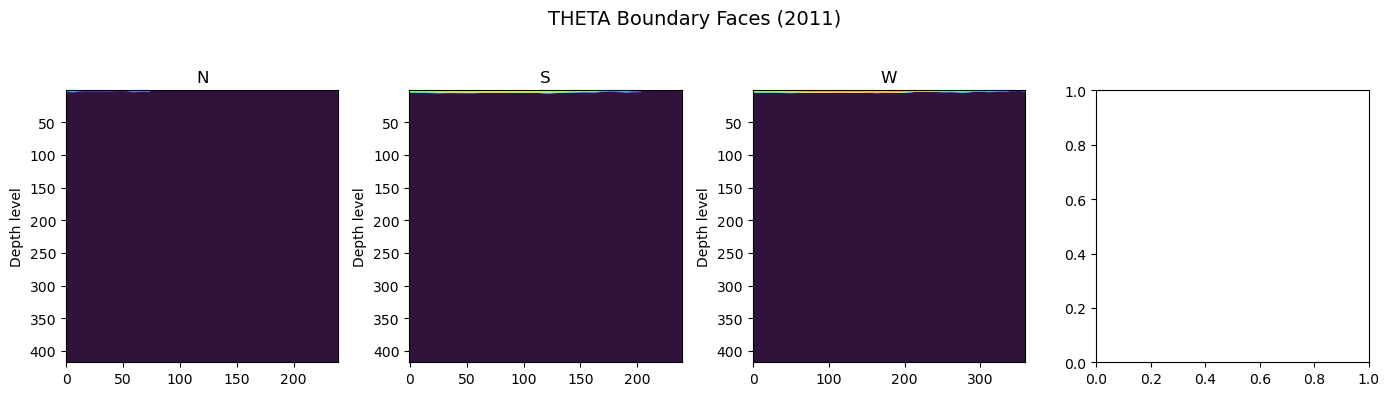

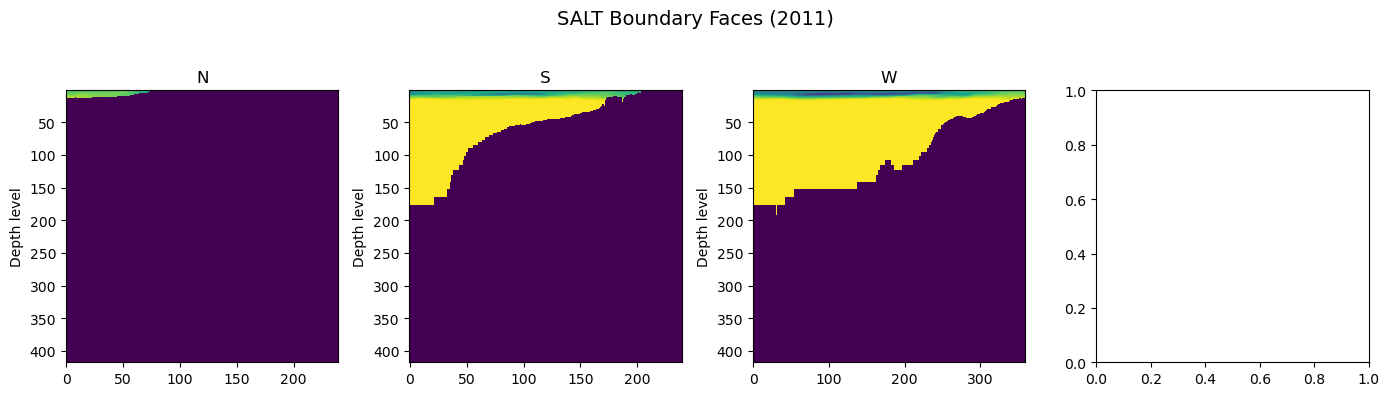

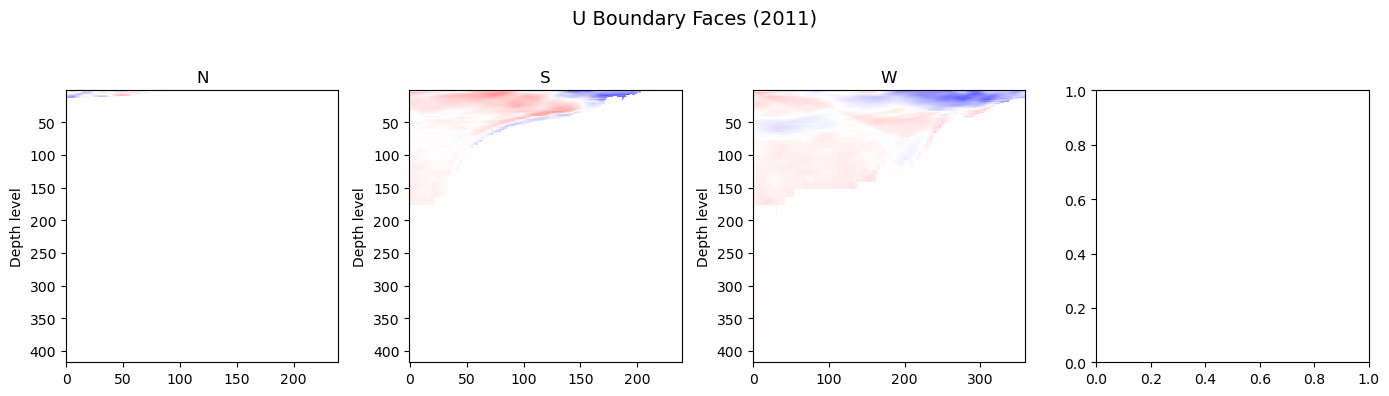

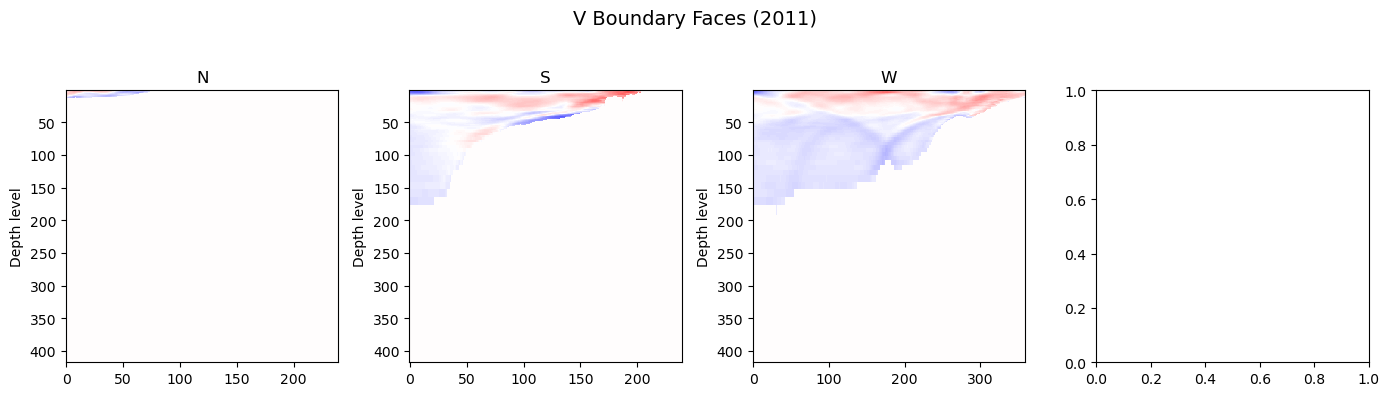

In [23]:
import matplotlib.pyplot as plt

boundaries = ['north', 'south', 'west']

for variable_name in variable_names:
    fig, axs = plt.subplots(1, 4, figsize=(14, 4))
    fig.suptitle(f'{variable_name} Boundary Faces (2011)', fontsize=14)
    
    for i, boundary in enumerate(boundaries):
        bc_file = os.path.join(input_dir, 'obcs', f'{variable_name}_{boundary}_2011.bin')
        if not os.path.exists(bc_file):
            print(f"Missing: {bc_file}")
            continue

        # Load binary file
        bc_data = np.fromfile(bc_file, '>f4')

        # Reshape appropriately
        if variable_name == 'ETA':
            if boundary in ['N', 'S']:
                bc_data = bc_data.reshape((np.shape(XC)[1],))  # 1D
                axs[i].plot(bc_data)
            else:
                bc_data = bc_data.reshape((np.shape(XC)[0],))
                axs[i].plot(bc_data)
        else:
            if boundary in ['N', 'S']:
                bc_data = bc_data.reshape((len(delR), np.shape(XC)[1]))
                axs[i].pcolormesh(np.arange(np.shape(XC)[1]), delR, bc_data, shading='auto',
                                  cmap=meta_dict[variable_name][2],
                                  vmin=meta_dict[variable_name][0],
                                  vmax=meta_dict[variable_name][1])
                axs[i].set_ylabel('Depth level')
            else:
                bc_data = bc_data.reshape((len(delR), np.shape(XC)[0]))
                axs[i].pcolormesh(np.arange(np.shape(XC)[0]), delR, bc_data, shading='auto',
                                  cmap=meta_dict[variable_name][2],
                                  vmin=meta_dict[variable_name][0],
                                  vmax=meta_dict[variable_name][1])
                axs[i].set_ylabel('Depth level')
        
        axs[i].set_title(boundary)
        axs[i].invert_yaxis()
        #axs[i].set_ylim([1,0])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{variable_name}_OBCS_Faces.png', dpi=200)
    plt.show()

Looks good! Now we need to make our external forcing and boundary conditions before we're ready to run the model.

## Note: Slice ICs for BCs

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```

In [12]:
variable_names=['THETA','SALT','UVEL','VVEL']
boundaries = ['north', 'south', 'west']
os.chdir("/Users/alex/Desktop/MS274/demo/ModelPrep/obcs")

input_dir='/Users/alex/Desktop/MS274/demo/ModelPrep/'

for variable_name in variable_names:
    
    for i, boundary in enumerate(boundaries):
        bc_file = os.path.join(input_dir, 'obcs', f'{variable_name}_{boundary}_2011')
        if not os.path.exists(bc_file):
            print(f"Missing: {bc_file}")
            continue

        # Load binary file
        bc_data = np.fromfile(bc_file, '>f4')

        if boundary in ['north', 'south']:
            bc_data = bc_data.reshape((len(delR), np.shape(XC)[1]))
            bc_data_extended = np.zeros((12, len(delR), np.shape(XC)[1]))
            for i in range(12):
                bc_data_extended[i,:,:] = bc_data
            bc_data_extended.astype('>f4').tofile(os.path.join(input_dir, 'obcs_extended', variable_name+'_'+boundary+'_'+str(2011)))
        else:
            bc_data = bc_data.reshape((len(delR), np.shape(XC)[0]))
            bc_data_extended = np.zeros((12, len(delR), np.shape(XC)[0]))
            for i in range(12):
                bc_data_extended[i,:,:] = bc_data
            bc_data_extended.astype('>f4').tofile(os.path.join(input_dir, 'obcs_extended', variable_name+'_'+boundary+'_'+str(2011)))
        #axs[i].set_ylim([1,0])

ValueError: cannot reshape array of size 253440 into shape (88,240)